# Neighbourhood Analysis in Hong Kong

Import libraries for all three tasks.

In [295]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from bs4 import BeautifulSoup
import requests # library to handle requests
import json # library to handle json files

import re #library for regular expression operations to search strings

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


This study uses polling stations to indicate different neighbourhoods. Now scrape the information of polling stations from the government website.

In [5]:
#Define the links to the government website

areas = ['HK','Kowloon','NT']

link = "https://www.elections.gov.hk/dc2019/eng/poll_{}.html"
links = dict(zip(areas,[[],[],[]]))

#HK for Hong Kong island, Kowloon for Kowloon, NT for New Territorries
#HK, Kowloon and NT are three main areas in Hong Kong
codes = {'HK':['A','B','C','D'],
        'Kowloon':['E','F','G','H','J'],
        'NT':['K','L','M','N','P','Q','R','S','T']}

for area in areas:
    for i in codes[area]:
        links[area].append(link.format(i))

print(links['HK'],links['Kowloon'],links['NT'])

['https://www.elections.gov.hk/dc2019/eng/poll_A.html', 'https://www.elections.gov.hk/dc2019/eng/poll_B.html', 'https://www.elections.gov.hk/dc2019/eng/poll_C.html', 'https://www.elections.gov.hk/dc2019/eng/poll_D.html'] ['https://www.elections.gov.hk/dc2019/eng/poll_E.html', 'https://www.elections.gov.hk/dc2019/eng/poll_F.html', 'https://www.elections.gov.hk/dc2019/eng/poll_G.html', 'https://www.elections.gov.hk/dc2019/eng/poll_H.html', 'https://www.elections.gov.hk/dc2019/eng/poll_J.html'] ['https://www.elections.gov.hk/dc2019/eng/poll_K.html', 'https://www.elections.gov.hk/dc2019/eng/poll_L.html', 'https://www.elections.gov.hk/dc2019/eng/poll_M.html', 'https://www.elections.gov.hk/dc2019/eng/poll_N.html', 'https://www.elections.gov.hk/dc2019/eng/poll_P.html', 'https://www.elections.gov.hk/dc2019/eng/poll_Q.html', 'https://www.elections.gov.hk/dc2019/eng/poll_R.html', 'https://www.elections.gov.hk/dc2019/eng/poll_S.html', 'https://www.elections.gov.hk/dc2019/eng/poll_T.html']


In [6]:
#obtain the polling station tables

header = {
    'User-Agent': 'Mozilla/5.0'
}

page = requests.post(link, headers=header)
soup = BeautifulSoup(page.content)


tables = {'HK':dict(zip(codes['HK'],[ [] for _ in range(len(codes['HK']))])),
          'Kowloon':dict(zip(codes['Kowloon'],[ [] for _ in range(len(codes['Kowloon']))])),
          'NT':dict(zip(codes['NT'],[ [] for _ in range(len(codes['NT']))]))}


for area in tables.keys():
    for key in tables[area].keys():
        page = requests.post(link.format(key), headers=header)
        soup = BeautifulSoup(page.content)
        tables[area][key] = soup.find(id="table-district-member")
        tables[area][key] = soup.findAll('td')

Next step is to input the data into dataframe from the website tables. Firstly, we need to define the relationship between districts and their codes for polling stations.

In [8]:
#Code to district
district = {'A':'Central & Western District',
            'B':'Wan Chai District',
            'C':'Eastern District',
            'D':'Southern District',
            'E':'Yau Tsim Mong District',
            'F':'Sham Shui Po District',
            'G':'Kowloon City District',
            'H':'Wong Tai Sin District',
            'J':'Kwun Tong District',
            'K':'Tsuen Wan District',
            'L':'Tuen Mun District',
            'M':'Yuen Long District',
            'N':'North District',
            'P':'Tai Po District',
            'Q':'Sai Kung District',
            'R':'Sha Tin District',
            'S':'Kwai Tsing District',
            'T':'Islands District'}


Then input data into dataframes

In [15]:
columns = ["District","Constituency","Code","Polling Station","Address"]
dfs = {'HK':pd.DataFrame(columns = columns),
      'Kowloon':pd.DataFrame(columns = columns),
      'NT':pd.DataFrame(columns = columns)}


entry = [None]*5 #temporarily storing the row entry
for area in areas:
    
    row_index = 0
    
    for key in tables[area].keys():
        
        constituency_index = 0 #j is the constituency index for each district
        #print(key)
        
        for i in range(len(tables[area][key])): #i is the number of strings of each district
            
            #print(tables[area][key][i].text)
            if tables[area][key][i].text == key + "%02d" % int(constituency_index+1):
                flag = tables[area][key][i].text
                constituency_index = constituency_index+1
                column = 1
                Polling_station_index = 1 #l is the number of polling station with the same constituency
                #print(tables[i].text)

            elif tables[area][key][i].text[0:5] == flag + "%02d" % Polling_station_index:
                column = 2
                entry[column] = tables[area][key][i].text
                
                column = column + 1
                
            
            elif tables[area][key][i].text == 'Map':
                #print(entry[2])
                #print(tables[area][key][i].text)
                dfs[area].loc[row_index]=[district[key],entry[1],entry[2],entry[3],entry[4]]
                Polling_station_index = Polling_station_index + 1
                row_index = row_index + 1
                #print(row_index)
        
            else:
                entry[column] = tables[area][key][i].text
                column = column + 1
        
#check the data entries on HK island
dfs['HK']

,District,Constituency,Code,Polling Station,Address
0,Central & Western District,CHUNG WAN,A0101,H6 Conet,"G/F, The Center, 99 Queen's Road Central, Cent..."
1,Central & Western District,CHUNG WAN,A0102,Hong Kong Visual Arts Centre,"4/F, 7A Kennedy Road, Central, Hong Kong"
2,Central & Western District,MID LEVELS EAST,A0201,Raimondi College,"2 Robinson Road, Hong Kong"
3,Central & Western District,CASTLE ROAD,A0301,Hong Kong True Light Kindergarten (Caine Road),"G/F - 2/F, 75 Caine Road, Hong Kong"
4,Central & Western District,CASTLE ROAD,A0302,Ying Wa Girls' School,"76 Robinson Road, Mid-Levels, Hong Kong"
5,Central & Western District,PEAK,A0401,Hong Kong Park Sports Centre,"29 Cotton Tree Drive, Central, Hong Kong"
6,Central & Western District,PEAK,A0402,German Swiss International School Peak Campus,"Upper Building, German Swiss International Sch..."
7,Central & Western District,UNIVERSITY,A0501,Sai Ying Pun Community Complex Community Hall,"3/F, Sai Ying Pun Community Complex, 2 High St..."
8,Central & Western District,KWUN LUNG,A0601,Smithfield Sports Centre,"4/F, Smithfield Municipal Services Building, 1..."
9,Central & Western District,KENNEDY TOWN & MOUNT DAVIS,A0701,HKYWCA Western District Integrated Social Serv...,"Flat A, 1/F, Block 1, Centenary Mansion, 9-15 ..."


We need to revise the address to make it suitable for geopy. For example, the floor information and building name should be removed. Also for polling stations including several buildings, we simply keep one of the buildings and remove others.

In [16]:
find_num = re.compile(r'(.*?)[\d]', re.S)

for area in areas:
    
    #to remove floor number and building names
    #Note this step does not work for entries that do not have street numbers.
    #These entries will be revised again by following steps.
    k=0
    while k < len(dfs[area]['Address']):
        k = 0
        for i, address in enumerate(dfs[area]['Address']):
            try:
                
                address = address.replace(address[0:int(re.search(r', \d',address).start())+2],"")
                dfs[area]['Address'][i] = address
            
            except: 
                k = k + 1

    #Simplify the building number 
    k = 0
    while k < len(dfs[area]['Address']):
        k = 0
        for i, address in enumerate(dfs[area]['Address']):
            try:
                
                address = address.replace(address[0:int(re.search(r'- \d',address).start()+1)],"")
                dfs[area]['Address'][i] = address
            
            except: 
                k = k + 1
    
    #Remove the floor information again
    k = 0
    while k < len(dfs[area]['Address']):
        k = 0
        for i, address in enumerate(dfs[area]['Address']):
            try:

                address = address.replace(address[0:int(re.search(r'/F,',address).start()+4)],"")
                dfs[area]['Address'][i] = address
            
            except: 
                k = k + 1            
            
dfs['HK']

,District,Constituency,Code,Polling Station,Address
0,Central & Western District,CHUNG WAN,A0101,H6 Conet,"99 Queen's Road Central, Central, Hong Kong"
1,Central & Western District,CHUNG WAN,A0102,Hong Kong Visual Arts Centre,"7A Kennedy Road, Central, Hong Kong"
2,Central & Western District,MID LEVELS EAST,A0201,Raimondi College,"2 Robinson Road, Hong Kong"
3,Central & Western District,CASTLE ROAD,A0301,Hong Kong True Light Kindergarten (Caine Road),"75 Caine Road, Hong Kong"
4,Central & Western District,CASTLE ROAD,A0302,Ying Wa Girls' School,"76 Robinson Road, Mid-Levels, Hong Kong"
5,Central & Western District,PEAK,A0401,Hong Kong Park Sports Centre,"29 Cotton Tree Drive, Central, Hong Kong"
6,Central & Western District,PEAK,A0402,German Swiss International School Peak Campus,"11 Guildford Road, The Peak, Hong Kong"
7,Central & Western District,UNIVERSITY,A0501,Sai Ying Pun Community Complex Community Hall,"2 High Street, Sai Ying Pun, Hong Kong"
8,Central & Western District,KWUN LUNG,A0601,Smithfield Sports Centre,"12K Smithfield, Kennedy Town, Hong Kong"
9,Central & Western District,KENNEDY TOWN & MOUNT DAVIS,A0701,HKYWCA Western District Integrated Social Serv...,"9-15 Victoria Road, Western District, Hong Kong"


Now that we have the addresses of all polling stations, we will use geopy to get the latitude and longitude of the addresses. And integrate the location information into the above dataframe.

In [500]:
latitude = []
longitude = []
df_location = {'HK':pd.DataFrame(columns = ['Address','Latitude','Longitude']),
               'Kowloon':pd.DataFrame(columns = ['Address','Latitude','Longitude']),
               'NT':pd.DataFrame(columns = ['Address','Latitude','Longitude'])}

for area in areas:
    for i, address in enumerate(dfs[area]['Address']):
        try:
            geolocator = Nominatim(user_agent="hk_explorer")
            location = geolocator.geocode(address)
            df_location[area].loc[i]=[address,location.latitude,location.longitude]
        except:
            #Print the addresses that geopy cannot get the locations for
            print(area,i,address)
    
df_location['HK']

,Address,Latitude,Longitude
0,"99 Queen's Road Central, Central, Hong Kong",22.283650,114.154940
1,"7A Kennedy Road, Central, Hong Kong",22.276706,114.159361
2,"2 Robinson Road, Hong Kong",22.278408,114.153679
3,"75 Caine Road, Hong Kong",22.281955,114.151291
4,"76 Robinson Road, Mid-Levels, Hong Kong",22.282718,114.147223
5,"29 Cotton Tree Drive, Central, Hong Kong",22.277250,114.159306
6,"11 Guildford Road, The Peak, Hong Kong",22.265953,114.161964
7,"2 High Street, Sai Ying Pun, Hong Kong",22.284792,114.144139
8,"12K Smithfield, Kennedy Town, Hong Kong",22.281721,114.128484
9,"9-15 Victoria Road, Western District, Hong Kong",22.281902,114.125827


In [499]:
#Integrate the location information into the dataframe
for area in areas:
    dfs[area] = dfs[area].join(df_location[area].set_index('Address'), on='Address')

#Drop the entries without location information
for area in areas: 
    dfs[area].dropna(inplace=True)
    print(area,dfs[area].shape)

ValueError: columns overlap but no suffix specified: Index(['Latitude', 'Longitude'], dtype='object')

As we see, geopy cannot get location data of many addresses, especially for NT. However, some NT addresses are located on sparsely populated places like remote islands. Considering the purpose of the study is mainly on the city neighbourhood analysis, the sparsely populated neighbourhoods may not be important.

The distribution of the neighbourhoods with location data will be checked first.

In [24]:
#Get the location of Hong Kong (The location of Kowloon is used)
address = 'Kowloon, Hong Kong'

geolocator = Nominatim(user_agent="hk_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Hong Kong island are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Hong Kong island are 22.3116452, 114.1767885.


In [26]:
# create map of Toronto City using latitude and longitude values
map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
colors = ['red','blue','green']
for area, color in zip(areas, colors):
    for lat, lng, constituency, address in zip(dfs[area]['Latitude'], dfs[area]['Longitude'], dfs[area]['Constituency'], dfs[area]['Address']):
        label = '{}, {}'.format(constituency, address)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=color,
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map)  

    
map

From the above map, the neighbourhoods with data locations are distributed uniformly, thus effective for the neighbourhood analysis here.

Next, we are going to use Foursquare to get venue data for each neighbourhoods.

In [57]:
CLIENT_ID = '4ORWWNFRNAWZKEIWSUVLBVB4FJDXYDWYGEEYHX1PAQ1LY5NE' # your Foursquare ID
CLIENT_SECRET = 'ODJLX4FEQLR51DL55QU0RNUIU2YEJIH1EIDTA4RACRRXYW53' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4ORWWNFRNAWZKEIWSUVLBVB4FJDXYDWYGEEYHX1PAQ1LY5NE
CLIENT_SECRET:ODJLX4FEQLR51DL55QU0RNUIU2YEJIH1EIDTA4RACRRXYW53


Define the function to get nearby venues of each neighborhood.

In [63]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Scrape data from Foursquare

In [64]:
venues=dict(zip(areas,[[],[],[]]))

for area in areas:
    venues[area] = getNearbyVenues(names=dfs[area]['Polling Station'],
                                       latitudes=dfs[area]['Latitude'],
                                       longitudes=dfs[area]['Longitude']
                                      )


View the scraped data.

In [65]:
venues['NT']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Princess Alexandra Community Centre,22.371538,114.114586,民豐粉麵行,22.371518,114.117160,Noodle House
1,Princess Alexandra Community Centre,22.371538,114.114586,Chung Kee Dessert (松記糖水店),22.372064,114.115141,Dessert Shop
2,Princess Alexandra Community Centre,22.371538,114.114586,大良鴻輝記,22.372112,114.117038,Dessert Shop
3,Princess Alexandra Community Centre,22.371538,114.114586,Jade Garden (翠園),22.370674,114.113578,Cantonese Restaurant
4,Princess Alexandra Community Centre,22.371538,114.114586,Beans (荳子),22.371972,114.115612,Dessert Shop
5,Princess Alexandra Community Centre,22.371538,114.114586,康樂茶冰廳,22.372568,114.115662,Cha Chaan Teng
6,Princess Alexandra Community Centre,22.371538,114.114586,Genki Sushi (元気寿司),22.370528,114.111569,Sushi Restaurant
7,Princess Alexandra Community Centre,22.371538,114.114586,Ramen Taifu (拉麵台風),22.371487,114.115163,Ramen Restaurant
8,Princess Alexandra Community Centre,22.371538,114.114586,Isari Kiya (漁屋),22.368308,114.114772,Japanese Restaurant
9,Princess Alexandra Community Centre,22.371538,114.114586,山西刀削麵店,22.372432,114.115646,Noodle House


Summarize the number of venues at each neighborhood.

In [137]:
for area in areas:
    venues[area].groupby('Neighborhood').count()

#For following analysis, venues_tot is used.
venues_tot=pd.concat([venues['HK'],venues['Kowloon'],venues['NT']])

One hot encoding of the data.

In [138]:
onehot = dict(zip(areas,[[],[],[]]))

for area in areas:

    # one hot encoding
    onehot[area] = pd.get_dummies(venues[area][['Venue Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    onehot[area]['Neighborhood'] = venues[area]['Neighborhood'] 

    # move neighborhood column to the first column
    fixed_columns = [onehot[area].columns[-1]] + list(onehot[area].columns[:-1])
    onehot[area] = onehot[area][fixed_columns]

onehot_tot = pd.get_dummies(venues_tot[['Venue Category']], prefix="", prefix_sep="")
onehot_tot['Neighborhood'] = venues_tot['Neighborhood']
fixed_columns = [onehot_tot.columns[-1]] + list(onehot_tot.columns[:-1])
onehot_tot = onehot_tot[fixed_columns]

onehot_tot.head()

,Neighborhood,ATM,Accessories Store,American Restaurant,Amphitheater,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Balinese Restaurant,Bank,Bar,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Belgian Restaurant,Betting Shop,Bistro,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Cafeteria,Café,Camera Store,Campground,Candy Store,Cantonese Restaurant,Cha Chaan Teng,Cheese Shop,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dive Shop,Donburi Restaurant,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fujian Restaurant,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hong Kong Restaurant,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Housing Development,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Theater,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Jiangsu Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outlet Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Perfume Shop,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Print Shop,Pub,Public Art,Racecourse,Ramen Restaurant,Record Shop,Recreation Center,Reservoir,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Road,Rock Climbing Spot,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Satay Restaurant,Scandinavian Restaurant,Scenic Lookout,School,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Area,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Social Club,Soup Place,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Takoyaki Place,Tapas Restaurant,Tea Room,Temple,Tennis Court,Thai Restaurant,Theater,Theme Park,Tibetan Restaurant,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tram Station,Tunnel,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Xinjiang 

Summarize the one hot encoding data, the result of which can be used for clustering later.

In [177]:
grouped = dict(zip(areas,[[],[],[]]))
for area in areas:
    grouped[area] = onehot[area].groupby('Neighborhood').mean().reset_index()

grouped_tot = onehot_tot.groupby('Neighborhood').mean().reset_index()
grouped_tot.head()

,Neighborhood,ATM,Accessories Store,American Restaurant,Amphitheater,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Balinese Restaurant,Bank,Bar,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Belgian Restaurant,Betting Shop,Bistro,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Cafeteria,Café,Camera Store,Campground,Candy Store,Cantonese Restaurant,Cha Chaan Teng,Cheese Shop,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dive Shop,Donburi Restaurant,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fujian Restaurant,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hong Kong Restaurant,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Housing Development,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Theater,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Jiangsu Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outlet Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Perfume Shop,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Print Shop,Pub,Public Art,Racecourse,Ramen Restaurant,Record Shop,Recreation Center,Reservoir,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Road,Rock Climbing Spot,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Satay Restaurant,Scandinavian Restaurant,Scenic Lookout,School,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Area,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Social Club,Soup Place,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Takoyaki Place,Tapas Restaurant,Tea Room,Temple,Tennis Court,Thai Restaurant,Theater,Theme Park,Tibetan Restaurant,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tram Station,Tunnel,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Xinjiang 

Define the function and summarize the most common venues at each neighborhood. The result is integrated into a dataframe.

In [70]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [347]:
num_top_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = dict(zip(areas,[pd.DataFrame(columns=columns) for _ in range(3)]))

for area in areas:
    neighborhoods_venues_sorted[area]['Neighborhood'] = grouped[area]['Neighborhood']

    for ind in np.arange(grouped[area].shape[0]):
        neighborhoods_venues_sorted[area].iloc[ind, 1:] = return_most_common_venues(grouped[area].iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_tot = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_tot['Neighborhood'] = grouped_tot['Neighborhood']
for ind in np.arange(grouped_tot.shape[0]):
    neighborhoods_venues_sorted_tot.iloc[ind, 1:] = return_most_common_venues(grouped_tot.iloc[ind, :], num_top_venues)
        
neighborhoods_venues_sorted_tot.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,AD&FD POHL Leung Sing Tak College,Fast Food Restaurant,Coffee Shop,Pool,Café,Athletics & Sports,Zoo,Food Truck,Food,Food & Drink Shop,Food Court,French Restaurant,Flea Market,Fried Chicken Joint,Frozen Yogurt Shop,Fujian Restaurant,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Flower Shop
1,Aberdeen Sports Centre,Chinese Restaurant,Coffee Shop,Convenience Store,Cha Chaan Teng,Supermarket,Sushi Restaurant,Seafood Restaurant,Fast Food Restaurant,Athletics & Sports,Shopping Mall,Fish Market,Taiwanese Restaurant,Park,Thai Restaurant,Bus Station,Market,Noodle House,Hotpot Restaurant,River,Plaza
2,Aberdeen St. Peter's Catholic Primary School,Cha Chaan Teng,Fast Food Restaurant,Sushi Restaurant,Noodle House,Vegetarian / Vegan Restaurant,Park,Pharmacy,Coffee Shop,Taiwanese Restaurant,Athletics & Sports,Thai Restaurant,Shopping Mall,Plaza,Supermarket,Food Truck,Food & Drink Shop,French Restaurant,Fried Chicken Joint,Food,Frozen Yogurt Shop
3,Aberdeen Tennis and Squash Centre,Cha Chaan Teng,Sushi Restaurant,Jewelry Store,Athletics & Sports,Noodle House,Park,Pharmacy,Fast Food Restaurant,Supermarket,Taiwanese Restaurant,Thai Restaurant,BBQ Joint,Deli / Bodega,Australian Restaurant,Flower Shop,Accessories Store,Gas Station,Garden,Gaming Cafe,Furniture / Home Store
4,Aldrich Bay Government Primary School,Noodle House,Cha Chaan Teng,Chinese Restaurant,Dessert Shop,Indian Restaurant,Park,Harbor / Marina,Market,Fast Food Restaurant,Bakery,Cantonese Restaurant,Snack Place,Movie Theater,Hainan Restaurant,Pharmacy,BBQ Joint,Dim Sum Restaurant,Dumpling Restaurant,Farmers Market,English Restaurant
5,Aoi Pui School,Japanese Restaurant,Jewelry Store,Dessert Shop,Fast Food Restaurant,Noodle House,Dim Sum Restaurant,Hotpot Restaurant,Snack Place,Hotel,Cha Chaan Teng,Chinese Restaurant,BBQ Joint,Shabu-Shabu Restaurant,Taiwanese Restaurant,Grocery Store,Sushi Restaurant,Cantonese Restaurant,Supermarket,Movie Theater,Burger Joint
6,Ap Lei Chau Community Hall,Fast Food Restaurant,Park,Convenience Store,Coffee Shop,Burger Joint,Chinese Restaurant,Harbor / Marina,Shopping Mall,Shanghai Restaurant,Fish Market,Hong Kong Restaurant,Hostel,Bakery,Bus Station,Accessories Store,Asian Restaurant,Field,Food Court,Garden,Gaming Cafe
7,Ap Lei Chau Sports Centre,Chinese Restaurant,Fast Food Restaurant,Sushi Restaurant,Seafood Restaurant,Convenience Store,Coffee Shop,BBQ Joint,Cha Chaan Teng,Paper / Office Supplies Store,Grocery Store,Shopping Mall,Park,Thai Restaurant,Market,Pharmacy,Burger Joint,Vegetarian / Vegan Restaurant,Hotel,River,American Restaurant
8,Asian Outreach Hong Kong Island Harbourview El...,Hotel,Coffee Shop,Cantonese Restaurant,Shopping Mall,Chinese Restaurant,Noodle House,Fast Food Restaurant,Vietnamese Restaurant,Hong Kong Restaurant,Mediterranean Restaurant,Thai Restaurant,Gym / Fitness Center,Modern European Restaurant,Grocery Store,Park,Supermarket,Golf Course,Malay Restaurant,Cocktail Bar,Burger Joint
9,BTCFS Yeung Yat Lam Memorial School,Italian Restaurant,Chinese Restaurant,Ramen Restaurant,Shopping Mall,Supermarket,Indian Restaurant,Food & Drink Shop,Fish & Chips Shop,Indie Theater,Fish Market,Flea Market,Flower Shop,Food,Food Court,Ice Cream Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fujian Restaurant


Clustering of the neighborhoods.

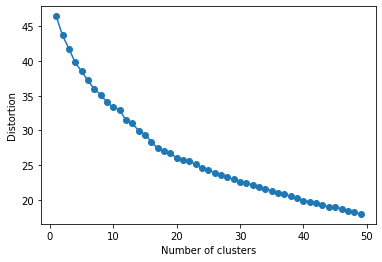

In [299]:
#To determine the k first
distortions = []
for kclusters in range(1, 50):
    kmeans_tot = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering_tot)
    distortions.append(kmeans_tot.inertia_)

plt.plot(range(1, 50), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [328]:
# set number of clusters
kclusters = 12

grouped_clustering = dict(zip(areas,[pd.DataFrame(columns=columns) for _ in range(3)]))
kmeans = dict(zip(areas,[pd.DataFrame(columns=columns) for _ in range(3)]))

grouped_clustering_tot = pd.DataFrame(columns=columns)
kmeans_tot = pd.DataFrame(columns=columns)

for area in areas:
    grouped_clustering[area] = grouped[area].drop('Neighborhood', 1)

    # run k-means clustering
    kmeans[area] = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering[area])

grouped_clustering_tot = grouped_tot.drop('Neighborhood', 1)
kmeans_tot = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering_tot)

# check cluster labels generated for each row in the dataframe
kmeans_tot.labels_[0:10] 

array([1, 5, 2, 5, 2, 2, 2, 6, 5, 0])

Add clustering labels into the dataframe.

In [346]:
#This step is to remove the outliers of the clustering and re-index clusters 
labels = kmeans_tot.labels_.astype('float')
label_values, label_counts = np.unique(kmeans_tot.labels_, return_counts = True)
label_values = label_values.astype('float')

k=0
for i in range(kclusters):
    if (label_counts[i]<10):
        labels[labels==i]='nan'
    else:
        labels[labels==i]=k
        k=k+1


In [349]:
merged = dict(zip(areas,[pd.DataFrame(columns=columns) for _ in range(3)]))

# add clustering labels

neighborhoods_venues_sorted['HK'].insert(0, 'Cluster Labels', 
                                         labels[0:len(kmeans['HK'].labels_)])
neighborhoods_venues_sorted['Kowloon'].insert(0, 'Cluster Labels', labels[len(kmeans['HK'].labels_):(len(kmeans['HK'].labels_)+len(kmeans['Kowloon'].labels_))])
neighborhoods_venues_sorted['NT'].insert(0, 'Cluster Labels', 
                                         labels[(len(kmeans['HK'].labels_)+len(kmeans['Kowloon'].labels_)):])

for area in areas:
    merged[area] = dfs[area]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
    merged[area] = merged[area].join(neighborhoods_venues_sorted[area].set_index('Neighborhood'), on='Polling Station')

for area in areas:
    merged[area].dropna(inplace=True)

merged['HK'] # check the last columns!

,District,Constituency,Code,Polling Station,Address,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Central & Western District,CHUNG WAN,A0101,H6 Conet,"99 Queen's Road Central, Central, Hong Kong",22.283650,114.154940,4.0,Coffee Shop,Bar,Japanese Restaurant,Cocktail Bar,Gym / Fitness Center,Hotel,Chinese Restaurant,BBQ Joint,French Restaurant,Yoga Studio,Italian Restaurant,Wine Bar,Modern European Restaurant,Gym,Indian Restaurant,Massage Studio,Salad Place,Spa,Ice Cream Shop,Clothing Store
1,Central & Western District,CHUNG WAN,A0102,Hong Kong Visual Arts Centre,"7A Kennedy Road, Central, Hong Kong",22.276706,114.159361,2.0,Hotel,Park,Botanical Garden,Chinese Restaurant,Café,Zoo,Spa,Szechuan Restaurant,Supermarket,Gym / Fitness Center,Plaza,French Restaurant,Lounge,Cocktail Bar,Coffee Shop,Cupcake Shop,Dim Sum Restaurant,Tea Room,Speakeasy,Thai Restaurant
2,Central & Western District,MID LEVELS EAST,A0201,Raimondi College,"2 Robinson Road, Hong Kong",22.278408,114.153679,1.0,Coffee Shop,Italian Restaurant,Japanese Restaurant,Bar,French Restaurant,Hotel,Chinese Restaurant,Cocktail Bar,Gastropub,Speakeasy,Café,Restaurant,Supermarket,Social Club,Spa,Lebanese Restaurant,Vietnamese Restaurant,Gym,Gym / Fitness Center,Yoga Studio
3,Central & Western District,CASTLE ROAD,A0301,Hong Kong True Light Kindergarten (Caine Road),"75 Caine Road, Hong Kong",22.281955,114.151291,1.0,Coffee Shop,Café,Japanese Restaurant,Italian Restaurant,French Restaurant,Vietnamese Restaurant,Bar,BBQ Joint,Cocktail Bar,Gym / Fitness Center,Beer Store,Hotel,Vegetarian / Vegan Restaurant,Ramen Restaurant,Yoga Studio,Massage Studio,Gastropub,Pakistani Restaurant,Social Club,Shanghai Restaurant
4,Central & Western District,CASTLE ROAD,A0302,Ying Wa Girls' School,"76 Robinson Road, Mid-Levels, Hong Kong",22.282718,114.147223,2.0,Café,Coffee Shop,Vietnamese Restaurant,Bar,Japanese Restaurant,Beer Store,Thai Restaurant,Grocery Store,Dim Sum Restaurant,French Restaurant,Steakhouse,Bookstore,Mexican Restaurant,Sushi Restaurant,Scandinavian Restaurant,Park,Garden,Tea Room,Arts & Crafts Store,Creperie
5,Central & Western District,PEAK,A0401,Hong Kong Park Sports Centre,"29 Cotton Tree Drive, Central, Hong Kong",22.277250,114.159306,3.0,Café,Hotel,Chinese Restaurant,Botanical Garden,Bar,Japanese Restaurant,Park,Gym,Spa,French Restaurant,Bookstore,Gym / Fitness Center,Speakeasy,Shopping Mall,Zoo,Szechuan Restaurant,Cocktail Bar,Coffee Shop,Cupcake Shop,Cycle Studio
6,Central & Western District,PEAK,A0402,German Swiss International School Peak Campus,"11 Guildford Road, The Peak, Hong Kong",22.265953,114.161964,3.0,Grocery Store,Noodle House,Bus Stop,Italian Restaurant,Boutique,Food Court,German Restaurant,Gastropub,Garden,Gaming Cafe,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Flower Shop,Gourmet Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant
7,Central & Western District,UNIVERSITY,A0501,Sai Ying Pun Community Complex Community Hall,"2 High Street, Sai Ying Pun, Hong Kong",22.284792,114.144139,0.0,Coffee Shop,Café,Cha Chaan Teng,Thai Restaurant,French Restaurant,Chinese Restaurant,Dessert Shop,Tapas Restaurant,Indian Restaurant,Park,Hong Kong Restaurant,Hotel,Restaurant,Cantonese Restaurant,Garden,Burger Joint,Speakeasy,Steakhouse,Supermarket,Japanese Restaurant
8,Central & Western District,KWUN LUNG,A0601,Smithfield Sports Centre,"12K Smithfield, Kennedy Town, Hong Kong",22.281721,114.128484,1.0,Coffee Shop,Japanese Restaurant,Vietnamese Restaurant,Chinese Restaurant,Mexican Restaura

In [342]:
#remove the nan values
for area in areas:
    merged[area].dropna(inplace=True)

Generate the map visualizing how the neighborhoods cluster together.

In [354]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['HK']['Latitude'], merged['HK']['Longitude'], merged['HK']['Polling Station'], merged['HK']['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.Circle(
        [lat, lon],
        radius=100,
        popup=label,
        color=rainbow[2*int(cluster-1)],
        fill=True,
        fill_color=rainbow[2*int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
    
for lat, lon, poi, cluster in zip(merged['Kowloon']['Latitude'], merged['Kowloon']['Longitude'], merged['Kowloon']['Polling Station'], merged['Kowloon']['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.Rectangle(
        [(lat, lon),(lat+0.0015, lon+0.0015)],
        popup=label,
        color=rainbow[2*int(cluster-1)],
        fill=True,
        fill_color=rainbow[2*int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)

for lat, lon, poi, cluster in zip(merged['NT']['Latitude'], merged['NT']['Longitude'], merged['NT']['Polling Station'], merged['NT']['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.Polygon(
        [(lat, lon),(lat+0.0015, lon+0.0015),(lat, lon+0.0015)],
        popup=label,
        color=rainbow[2*int(cluster-1)],
        fill=True,
        fill_color=rainbow[2*int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)    

map_clusters

To get the distribution of clusters in each area.

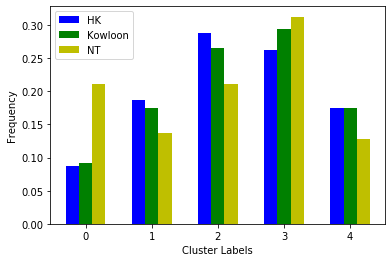

In [384]:
x_cluster_labels = {'HK':[-0.2,0.8,1.8,2.8,3.8],
    'Kowloon':[0,1,2,3,4],
    'NT':[0.2,1.2,2.2,3.2,4.2]}
y_frequency = {'HK':merged['HK'].groupby('Cluster Labels').count()['District']/merged['HK'].shape[0],
              'Kowloon':merged['Kowloon'].groupby('Cluster Labels').count()['District']/merged['Kowloon'].shape[0],
              'NT':merged['NT'].groupby('Cluster Labels').count()['District']/merged['NT'].shape[0]}
colors = ['b','g','y']

for area, color in zip(areas,colors):
    plt.bar(x_cluster_labels[area], y_frequency[area], width=0.2,label=area, fc=color)

plt.xlabel('Cluster Labels')
plt.ylabel('Frequency')

plt.legend()
plt.show()

Analyze the difference between different clusters by summarizing the most common venue in each neighbourhood.

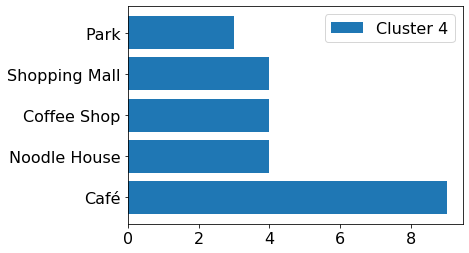

In [497]:
merged_tot = pd.concat([merged['HK'],merged['Kowloon'],merged['NT']])
x,y=[],[]
for i in range(5):
    temp = merged_tot[merged_tot['Cluster Labels']==i].groupby('1st Most Common Venue').count().drop(index=['Fast Food Restaurant','Chinese Restaurant'])
    common_venues = pd.DataFrame(columns = ['Frequence'])
    common_venues['Frequence'] = temp['Code']
    x.append(common_venues.sort_values('Frequence',ascending=False)[0:5].index)
    y.append(common_venues.sort_values('Frequence',ascending=False)[0:5]['Frequence'])
    
plt.barh(x[4],y[4],label='Cluster 4')
plt.tick_params(labelsize=16)
plt.legend(prop={'size':16})